# Configuration
____________________

In [ ]:
# set main directories
BASE_DIR = '/content/gdrive/MyDrive/AML_project/project/'
UTILS_DIR = BASE_DIR + 'utils'
DATA_DIR = BASE_DIR + 'data/'
TOKENIZER_DIR = BASE_DIR + 'tokenizers/'
MODEL_DIR = BASE_DIR + 'models/'
PRED_DIR = BASE_DIR + 'predictions/'
# mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# set utils directory
import sys
sys.path.append(UTILS_DIR)


Mounted at /content/gdrive


# Imports
____________________

In [ ]:
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import nltk
import string
import re
import io
from tensorflow import keras, random
from tensorflow.keras import layers, regularizers, callbacks, metrics, initializers
from keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D, Input, Concatenate, Flatten, Dropout, SpatialDropout1D, LSTM, GRU, Bidirectional, GlobalAvgPool1D, GlobalMaxPool1D
from keras.models import Model, load_model, save_model
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
# custom imports
from utils import getComments, train_val_split
from preprocessing import Preprocessor
from embeddings import load_glove_vectors, load_fasttext_vectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Setup

In [ ]:
### SETTINGS ###
settings = {
      'RANDOM_STATE': 42,
      'EMBEDDING_CHOICE': 'fasttext', # 'fasttext', 'glove'
      'SOURCES': ['de', 'fr', 'es'], # ['de', 'fr', 'es', 'syn_0', 'syn_1', 'syn_2'], use [] to keep only original data 
      'TEST_SIZE': 0.2,
      'UNDERSAMPLE': False
}
# set seeds
seed(settings['RANDOM_STATE'])
random.set_seed(settings['RANDOM_STATE'])
# shortcut
labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
targets = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate', 'is_toxic']

# Load data
____________________

In [ ]:
# load train
if settings['UNDERSAMPLE']:
  train = pd.read_csv(DATA_DIR + 'train_aug_und_cleaned.csv', sep='\t')
else:
  train = pd.read_csv(DATA_DIR + 'train_aug_cleaned.csv', sep='\t')

# load test
test = pd.read_csv(DATA_DIR + 'test_cleaned.csv', sep='\t')

# load test labels
test_labels = pd.read_csv(DATA_DIR + 'test_labels_cleaned.csv', sep='\t')

# Prepare data for model inputs
____________________

## Multilabel model

In [ ]:
# instantiate Preprocessor object
p_2 = Preprocessor(path_to_tokenizer=TOKENIZER_DIR + 'base_tokenizer.pickle')
# change num_words for toxic tokenizer
p_2.getTokenizer().num_words = 20000

It is necessary that during the split between training set and validation set, the augmented data will be added to the same set of their original values to avoid overfitting.

In [ ]:
# split in train and validation
X_train_2, X_val_2, y_train_2, y_val_2 = train_val_split(X = train[train['is_toxic']==1],
                                                          targets=targets,
                                                          val_size=settings['TEST_SIZE'],
                                                          random_state=settings['RANDOM_STATE'], 
                                                          sources=settings['SOURCES'])

y_train_2 = y_train_2[labels]
y_val_2 = y_val_2[labels]

y_test_2 = test_labels[test_labels['is_toxic']==1][labels]
X_test_2 = test.loc[y_test_2.index, 'comment_text'] 

Augmenting with de ...
Augmenting with fr ...
Augmenting with es ...


In [ ]:
print('Training size:', len(X_train_2))
print('Validation size:', len(X_val_2))
print('Test size:', len(X_test_2))
print('Split ratio:', round(len(X_val_2)/len(X_train_2), 2))

Training size: 51876
Validation size: 12972
Test size: 6242
Split ratio: 0.25


In [ ]:
# fit tokenizer
p_2.fitTokenizer(X_train_2)
print('Vocabulary 2 size: ',p_2.getVocabularySize())

Vocabulary 2 size:  39488


In [ ]:
# save fitted toxic tokenizer
p_2.saveTokenizer(TOKENIZER_DIR + 'fitted_multilabel_tokenizer_gru')

In [ ]:
# transform train, val and test comments to sequences
X_train_2 = p_2.toSequences(X_train_2)
X_val_2 = p_2.toSequences(X_val_2)
X_test_2 = p_2.toSequences(X_test_2)

In [ ]:
# load embedding
if settings['EMBEDDING_CHOICE'] == 'glove':
  embeddings_2 = load_glove_vectors(DATA_DIR + 'glove/glove.twitter.27B.200d.txt', p_2.getTokenizer())
if settings['EMBEDDING_CHOICE'] == 'fasttext':
  embeddings_2 = load_fasttext_vectors(DATA_DIR + 'fasttext/crawl-300d-2M.vec', p_2.getTokenizer())

print('Embeddings 2 shape: ', embeddings_2.shape)

Loading FastText Model and building embedding matrix with vocabulary...
DONE
Embeddings 2 shape:  (39488, 300)


# utils

In [ ]:
#import pickle
#with open(base_dir + 'history', 'wb') as file_pi:
#        pickle.dump(history.history, file_pi)
def saveWordIndexes(tokenizer):
  with open(base_dir + 'saved_model/word_index.json', 'w') as fp:
    json.dump(tokenizer.word_index, fp)

def plotHistory(history, metrics, title):
  plt.title(title)
  plt.plot(history.history[metrics[0]])
  plt.plot(history.history[metrics[1]])
  plt.ylabel(metrics[0])
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

def plot_roc(y_test, y_score):
  # plot settings
  lw = 2
  figure(figsize=(10,8))
  num_classes = 6
  y_test = np.array(y_test)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(num_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(num_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= num_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


  # Plot all ROC curves
  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(num_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(labels[i], roc_auc[i]))
  
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multilabel ROC CURVE')
  plt.legend(loc="lower right")
  plt.show()

def print_confusion_matrix(y_true, y_pred):
  i = 0
  for cm in multilabel_confusion_matrix(y_true, y_pred, samplewise=False):
    print('###################')
    print(labels[i])
    print(cm)
    i = i+1

# Build model - Bidirectional GRU
____________________

In [ ]:
def BiGRU(vocab_size, max_len, embedding, output_size):
  #### INITIALIZER
  initializer = initializers.GlorotUniform(seed=settings['RANDOM_STATE'])

  #### INPUT
  inputs = Input(shape=(max_len,))

  #### EMBEDDING LAYER
  embedding = Embedding(input_dim=vocab_size, output_dim=embedding.shape[1], weights=[embedding], 
                        input_length=max_len, trainable=False)(inputs)

  spatial = SpatialDropout1D(0.2)(embedding)
  
  #### GRU LAYER
  bilstm = Bidirectional(GRU(128, return_sequences=True, dropout=0.3, kernel_initializer=initializer))(spatial)

  # pools after GRU
  max_pool = GlobalMaxPool1D()(bilstm)
  avg_pool = GlobalAvgPool1D()(bilstm)

  # concatenate both pooling and use both info
  merged = Concatenate()([max_pool, avg_pool])
  

  #### FULLY CONNECTED LAYERS 
  dense1 = Dense(64, activation='relu', kernel_initializer=initializer)(merged)
  dropout = Dropout(0.3)(dense1)

  outputs = Dense(output_size, activation='sigmoid')(dropout)

  # compile model
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.Precision(), 'accuracy', metrics.AUC(multi_label=True)])
  print(model.summary())
  return model

## Create model - Multilabel classification
____________________

In [ ]:
model_multi = BiGRU(p_2.getVocabularySize(), p_2.getMaxLen(), embeddings_2, 6)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 300)     11846400    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 150, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 150, 256)     330240      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

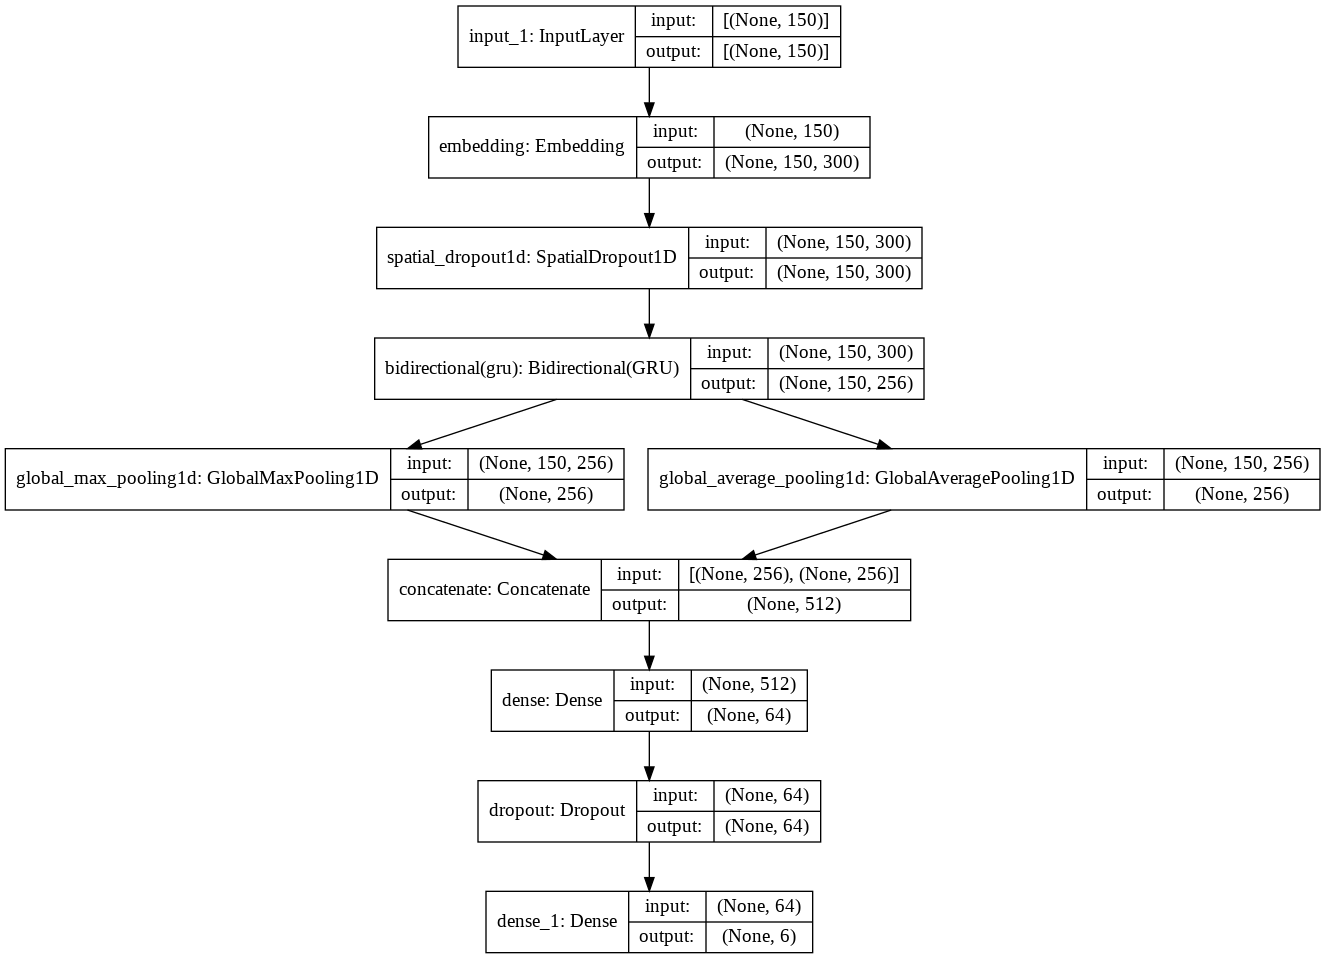

In [ ]:
plot_model(model_multi, show_shapes=True)

### Train model

In [ ]:
history_multi = model_multi.fit(X_train_2, y_train_2, batch_size=128, epochs=50,
                                callbacks=callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                                validation_data=(X_val_2, y_val_2))

Epoch 1/50
406/406 [==============================] - 51s 101ms/step - loss: 0.3731 - precision: 0.8065 - accuracy: 0.8976 - auc: 0.6718 - val_loss: 0.2674 - val_precision: 0.8662 - val_accuracy: 0.9427 - val_auc: 0.8724
Epoch 2/50
406/406 [==============================] - 39s 96ms/step - loss: 0.2834 - precision: 0.8582 - accuracy: 0.9332 - auc: 0.8393 - val_loss: 0.2539 - val_precision: 0.8623 - val_accuracy: 0.9431 - val_auc: 0.8904
Epoch 3/50
406/406 [==============================] - 39s 96ms/step - loss: 0.2706 - precision: 0.8620 - accuracy: 0.9412 - auc: 0.8629 - val_loss: 0.2447 - val_precision: 0.8806 - val_accuracy: 0.9433 - val_auc: 0.9002
Epoch 4/50
406/406 [==============================] - 39s 96ms/step - loss: 0.2610 - precision: 0.8647 - accuracy: 0.9433 - auc: 0.8744 - val_loss: 0.2444 - val_precision: 0.8450 - val_accuracy: 0.9441 - val_auc: 0.9097
Epoch 5/50
406/406 [==============================] - 39s 96ms/step - loss: 0.2512 - precision: 0.8667 - accuracy: 0.94

### Evaluation

Plot learning curves

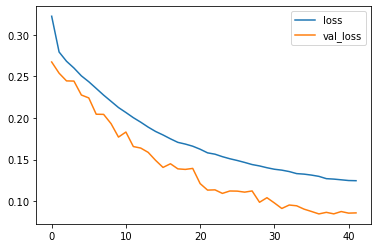

In [ ]:
pd_history_multi = pd.DataFrame(history_multi.history)
pd_history_multi.plot(y=['loss', 'val_loss'])

Make predictions on the test set

In [ ]:
y_score_multi = model_multi.predict(X_test_2)

Assign binary value to each label to compute accuracy

In [ ]:
threshold = 0.5
y_pred_multi = [[1 if label >= threshold else 0 for label in score] for score in y_score_multi]

Measure the performance of the model

In [ ]:
print('Accuracy (vector of labels must match):', round(accuracy_score(y_test_2, y_pred_multi), 5))
print('ROC AUC:', round(roc_auc_score(y_test_2, y_score_multi, average='macro'), 5))
print('Precision:', round(precision_score(y_test_2, y_pred_multi, average='macro'), 5))
print('Recall:', round(recall_score(y_test_2, y_pred_multi, average='macro'), 5))
print('F1 score:', round(f1_score(y_test_2, y_pred_multi, average='macro'), 5))
print(print_confusion_matrix(y_test_2, y_pred_multi))

Accuracy (vector of labels must match): 0.43207
ROC AUC: 0.84245
Precision: 0.67071
Recall: 0.67988
F1 score: 0.67159
###################
toxic
[[  13  140]
 [ 124 5965]]
###################
severe_toxic
[[5521  354]
 [ 204  163]]
###################
obscene
[[1664  888]
 [ 571 3119]]
###################
threat
[[5962   69]
 [ 116   95]]
###################
insult
[[1818  998]
 [ 802 2624]]
###################
identity_hate
[[5302  228]
 [ 289  423]]
None


## Save model and prediction

In [ ]:
# save model
model_multi.save(MODEL_DIR + 'gru_multi.h5', save_format='h5')
# save predictions
y_pred_multi = pd.DataFrame(y_pred_multi, columns=labels)
y_pred_multi.to_csv(PRED_DIR + 'gru_multi.csv', index=False, sep='\t')